# Regridding World Ocean Atlas 2023 data to match GFDL-MOM6-COBALT2 model outputs
**Author:** Denisse Fierro Arcos  
**Date:** 2024-10-01  
  
This script uses the cloud optimised WOA23 data (i.e., `zarr` files produced in the [02P_WOA_netcdf_to_zarr.ipynb](02P_WOA_netcdf_to_zarr.ipynb) script), regrids them to match outputs from GFDL-MOM6-COBALT2 and finally extracts data for all FishMIP regional models.

We use the FishMIP regional model shapefile, which is available via our THREDDS server. You can refer to this [notebook](https://github.com/Fish-MIP/FishMIP_regions/blob/main/scripts/02_Mapping_Regional_Models.md) for instructions on how to download this shapefile.

Additionally, you will need a mask containing all FishMIP regional models. Instructions on how to create this mask are available [here](https://github.com/Fish-MIP/FishMIP_regions/blob/main/scripts/03a_Regional_Models_2DMasks.md)

We recommend that you store both the shapefile and mask in the same folder.

## Loading libraries
We will load published Python libraries as well as our custom-made `useful_functions` library.

In [3]:
from dask.distributed import Client
import os
from glob import glob
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from glob import glob
import xesmf as xe

## Starting a cluster
This will allow us to automatically parallelising tasks on large datasets.

In [4]:
client = Client(threads_per_worker = 1)

2024-10-01 14:37:14,404 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:44397' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-xarray-<this-array>-77aee7873e5eba7ad557806551adfe2f'} (stimulus_id='handle-worker-cleanup-1727757434.4040587')
2024-10-01 14:37:33,432 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-10-01 14:37:33,434 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-10-01 14:37:33,435 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-10-01 14:37:33,436 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-10-01 14:37:33,437 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-10-01 14:37:33,438 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-10-01 14:37:33,438 - di

## Loading temperature data from GFDL-MOM6-COBALT2
We will use a single time step from the GFDL data as a sample to regrid the WOA data. Additionally, we will create a land mask to avoid issues with regridding along coastal grid cells.

In [22]:
# Load ocean temperature data from GFDL
base_gfdl = '/g/data/vf71/fishmip_inputs/ISIMIP3a/global_inputs/obsclim/025deg'
temp_gfdl = xr.open_dataarray(
    os.path.join(base_gfdl, 'gfdl-mom6-cobalt2_obsclim_thetao_15arcmin_global_monthly_1961_2010.nc'))

# Select the first time step as sample to regrid data
temp_gfdl = temp_gfdl.isel(time = 0).drop_vars('time')

# Rechunk and rename depth dimension to match WOA data
temp_gfdl = temp_gfdl.chunk({'lat': 144, 'lon': 288}).rename({'lev': 'depth'})

#Check results
temp_gfdl

<xarray.DataArray 'thetao' (depth: 35, lat: 720, lon: 1440)> Size: 145MB
dask.array<xarray-<this-array>, shape=(35, 720, 1440), dtype=float32, chunksize=(35, 144, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * lat      (lat) float64 6kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * depth    (depth) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    units:          degC
    GFDL_variable:  thetao

## Loading temperature data from World Ocean Atlas (WOA)
We will interpolate depth levels in WOA to match GFDL outputs.

In [20]:
base_woa = '/g/data/vf71/WOA_data/global'
temp_woa = xr.open_zarr(os.path.join(base_woa, 'woa23_clim_mean_temp_1981-2010.zarr/')).t_an
temp_woa = temp_woa.interp({'depth': temp_gfdl.depth.values})
temp_woa

<xarray.DataArray 't_an' (depth: 35, lat: 720, lon: 1440)> Size: 145MB
dask.array<transpose, shape=(35, 720, 1440), dtype=float32, chunksize=(35, 120, 240), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
Attributes:
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    standard_name:  sea_water_temperature
    units:          degrees_celsius

## Calculate regridder

In [23]:
# Calculate regridder
reg = xe.Regridder(temp_woa, temp_gfdl, method = 'conservative')
reg

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')


xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_720x1440_720x1440.nc 
Reuse pre-computed weights? False 
Input grid shape:           (720, 1440) 
Output grid shape:          (720, 1440) 
Periodic in longitude?      False

## Regridding temperature data

In [24]:
temp_woa_reg = reg(temp_woa)
temp_woa_reg

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:312: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 36.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (120, 240).
  result_var = func(*data_vars)


<xarray.DataArray (depth: 35, lat: 720, lon: 1440)> Size: 145MB
dask.array<astype, shape=(35, 720, 1440), dtype=float32, chunksize=(35, 120, 240), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * lat      (lat) float64 6kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
Attributes:
    regrid_method:  conservative

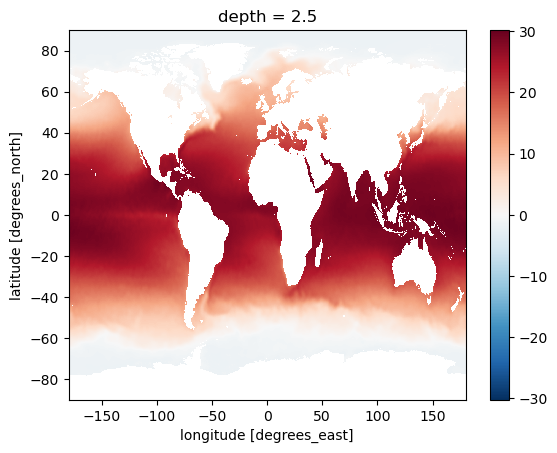

In [25]:
# Checking result
temp_woa_reg.isel(depth = 0).plot()

## Saving results

In [33]:
temp_woa_reg.to_zarr(os.path.join(base_woa, 'regridded_woa_clim_mean_temp_1981-2010.zarr'))

## Loading salinity data from World Ocean Atlas (WOA)
We will interpolate depth levels in WOA to match GFDL outputs.

In [29]:
salt_woa = xr.open_zarr(os.path.join(base_woa, 'woa23_clim_mean_sal_1981-2010.zarr/')).s_an
salt_woa = salt_woa.interp({'depth': temp_gfdl.depth.values})
salt_woa

<xarray.DataArray 's_an' (depth: 35, lat: 720, lon: 1440)> Size: 145MB
dask.array<transpose, shape=(35, 720, 1440), dtype=float32, chunksize=(35, 120, 240), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
Attributes:
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    long_name:      Objectively analyzed mean fields for sea_water_practical_...
    standard_name:  sea_water_practical_salinity
    units:          1

## Regridding salinity data

In [30]:
salt_woa_reg = reg(salt_woa)
salt_woa_reg

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:312: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 36.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (120, 240).
  result_var = func(*data_vars)


<xarray.DataArray (depth: 35, lat: 720, lon: 1440)> Size: 145MB
dask.array<astype, shape=(35, 720, 1440), dtype=float32, chunksize=(35, 120, 240), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * lat      (lat) float64 6kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
Attributes:
    regrid_method:  conservative

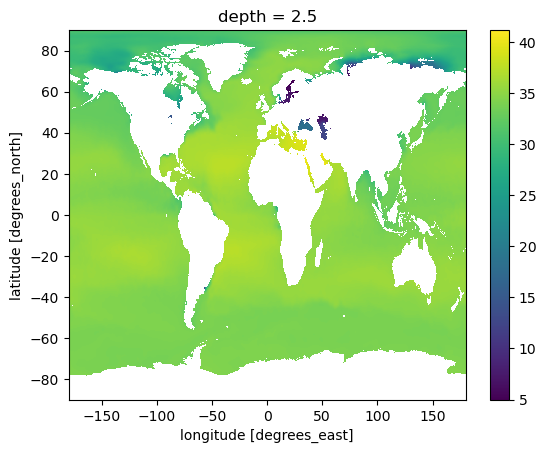

In [31]:
# Checking result
salt_woa_reg.isel(depth = 0).plot()

## Saving results

In [34]:
salt_woa_reg.to_zarr(os.path.join(base_woa, 'regridded_woa_clim_mean_sal_1981-2010.zarr'))

## Loading FishMIP regions mask and shapefile

In [40]:
# Define folder with shared resources
shared_res = '/g/data/vf71/shared_resources'
# Loading shapefile
rmes = gpd.read_file(
    os.path.join(shared_res, 'FishMIP_regional_models/FishMIP_regional_models.shp'))

# Loading mask
mask_ras = xr.open_dataset(
    os.path.join(shared_res, 'FishMIPMasks/merged_regional_fishmip',
                 'gfdl-mom6-cobalt2_areacello_15arcmin_fishMIP_regional_merged.nc')).region
#Renaming coordinate dimensions
mask_ras = mask_ras.rename({'latitude': 'lat', 'longitude': 'lon'})
#Rechunking data to make it more manageable
mask_ras = mask_ras.chunk({'lat': 144, 'lon': 288})

## Defining functions to mask and extract data

In [54]:
def mask_data(da, mask):
    '''
    Open netCDF files in analysis ready data (ARD) format. That is apply chunks
    that make data analysis easier.
    
    Inputs:
    da (data array): Data array containing data to be extracted
    mask_ras (boolean data array): Data array to be used as initial mask
    to decrease the size of the original dataset. This mask makes no distinction
    between regional models, it simply identifies grid cells within regional 
    model boundaries with the value of 1.
    
    Outputs:
    da (data array): ARD data array containing data only for grid cells within
    regional model boundaries.
    '''
    
    da_mask = da.where(mask_ras == 1)
    da_mask.rio.set_spatial_dims(x_dim = 'lon', y_dim = 'lat', inplace = True)
    da_mask.rio.write_crs('epsg:4326', inplace = True)
    da_mask = da_mask.chunk({'lat': 144, 'lon': 288})
    return da_mask

In [66]:
def clip_data(da, region, file_out):
    '''
    Open netCDF files in analysis ready data (ARD) format. That is apply chunks
    that make data analysis easier.
    
    Inputs:
    da (data array): Data array containing data to be extracted
    region (shapefile): Shapefile containing the boundaries of regional models
    file_out (character): Full file path where masked data should be stored.
    
    Outputs:
    No data is returned, but masked file will be stored in specified file path.
    '''
    #Clip data using regional shapefile
    da_mask = da.rio.clip(region.geometry, region.crs, drop = True, 
                          all_touched = True)
    #Remove spatial information
    da_mask = da_mask.drop_vars('spatial_ref')
    da_mask.encoding = {}

    #Keep data array attributes to be recorded in final data frame
    da_attrs = da.attrs
    da_attrs = pd.DataFrame([da_attrs])
    #Set column order
    ind_wider = ['lat', 'lon', 'depth', 'vals']
    #Turn extracted data into data frame and remove rows with NA values
    df = da_mask.to_series().to_frame().reset_index().dropna()
    #Changing column name to standardise across variables
    df = df.rename(columns = {da.name: 'vals'}).reset_index(drop = True)
    #Reorganise data
    df = df[ind_wider]
    #Include original dataset attributes
    df = pd.concat([df, da_attrs], axis = 1)
    #Saving data frame
    df.to_parquet(file_out)

## Extracting regridded WOA data for each region

In [44]:
base_out = '/g/data/vf71/WOA_data/regional/climatology/comp_clim'
os.makedirs(base_out, exist_ok = True)

In [74]:
temp_masked = mask_data(temp_woa_reg, mask_ras)
temp_masked.name = 'temperature'

for i in rmes.region:
    #Get polygon for each region
    mask = rmes[rmes.region == i]
    #Get name of region and clean it for use in output file
    reg_name = mask['region'].values[0].lower().replace(" ", "-").replace("'", "")
    #File name out - Replacing "global" for region name
    file_out = f'regridded_woa23_{reg_name}_clim_mean_temp_1981-2010.parquet'
    full_path_out = os.path.join(base_out, file_out)
    clip_data(temp_masked, mask, full_path_out)

In [75]:
sal_masked = mask_data(salt_woa_reg, mask_ras)
sal_masked.name = 'salinity'

for i in rmes.region:
    #Get polygon for each region
    mask = rmes[rmes.region == i]
    #Get name of region and clean it for use in output file
    reg_name = mask['region'].values[0].lower().replace(" ", "-").replace("'", "")
    #File name out - Replacing "global" for region name
    file_out = f'regridded_woa23_{reg_name}_clim_mean_sal_1981-2010.parquet'
    full_path_out = os.path.join(base_out, file_out)
    clip_data(sal_masked, mask, full_path_out)